# Initiate DB connection

In [26]:
import mysql.connector
import config


def init_db():
    return mysql.connector.connect(
            host = config.configSQLCrawler.HOST,
            user = config.configSQLCrawler.USER,
            passwd = config.configSQLCrawler.PASSWD,
            database = config.configSQLCrawler.DATABASE,
            port = config.configSQLCrawler.PORT,
            auth_plugin=config.configSQLCrawler.AUTH_PLUGIN
        )

def get_cursor(con):
    try:
        con.ping(reconnect=True, attempts=3, delay=5)
    except mysql.connector.Error as e:
        raise Exception('db error')
    return con.cursor(buffered=True)

db = init_db()
cursor = get_cursor(db)

# Get only id and text data

In [27]:
sql = """
        SELECT id, text
        FROM not_yet_stopwords

        LIMIT 1000000
"""
args = ('in',)

cursor.execute(sql,
                # args
                )
id_text_data = cursor.fetchall()

# Load data into pandas dataframe

In [28]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

id_text_df = pd.DataFrame(id_text_data, columns=['id','text'])

In [29]:
len(id_text_df)

100350

In [30]:
id_text_df.head() # to see sample data

,id,text
0,51,staycation sini nyaman banget dekat dengan pusat belanja dan pantai sanur banyak spot instagramable yg ada sini mural kamar nya bagus banget adem dan kolam renang bagus view sunsetnyabuat kak nimas good service deh ya
1,52,saya bawa grup pada desember lalu dengan beberapa butuh yg beda dari tiap grup pihak hotel cukup bantu dalam penuh butuh sebut staff hotel cukup ramah dan menu sarap baik
2,53,fasilitas hotel sangat lengkap lokasi dekat dengan fasilitas apotek dan pantai kamar gaya modern sangat cocok untuk libur maupun jalan bisnis samping itu makan enak ruang rapat nyaman dan ada fasilitas rekreasi meja billyard telah penat rapat
3,54,fasilitas ok samping pantai cocok buat honey moon breakfast lengkap dengan gabung indonesia dan wsetren food kamar rapi tiap hari jadi tidak perlu takut dengan sprai yang bau beri alam bagus untuk meeting
4,55,makan dan minum enak banget dan meetingnya nyaman bgttt terus nginap di hotel paket lengkap banget jadi semua serba dilayanin banget servicenya gila sih the best deh pokok soon balik lagi


In [2]:
import unicodedata as uni

def handle_unicode(text):
    return uni.normalize('NFKD', text)

handle_unicode('ℍ𝕖𝕝𝕝𝕠 𝕎𝕠𝕣𝕝𝕕!') # output: Hello World!


import demoji
def handle_emoji(text):
    return demoji.replace(text, "")

handle_emoji('Hello World😁') #output: Hello World



'Hello World'

In [31]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import demoji
import unicodedata as uni
import re

factory = StemmerFactory()
stemmer = factory.create_stemmer()


def handle_emoji(text):
    emoji_less_text = demoji.replace(text, "")

    return emoji_less_text

def handle_unicode(text):
    text = uni.normalize('NFKD', text)

    return text

def remove_stopwords(text, stopwordsfile):
    stopwords_list = [word.strip() for word in open(stopwordsfile).readlines()]
    return ' '.join([word.strip() for word in text.split() if word.strip() not in stopwords_list])

def stemming(text):
    return stemmer.stem(text)

# define function to pre-process text column
def preprocess(text):
    # text = handle_emoji(text)
    # text = handle_unicode(text)
    # text = text.replace(r'\n', ' ')
    # text = text.lower()
    # text = re.sub('[^a-z ]+', '', text)
    text = remove_stopwords(text, ".\stopwords\stopword_list1.txt")
    # text = stemming(text)
    text_list = [word.strip() for word in text.split()]
    return text_list


In [32]:
id_text_df['text'] = id_text_df['text'].progress_apply(preprocess)

100%|██████████| 100350/100350 [01:10<00:00, 1420.55it/s]


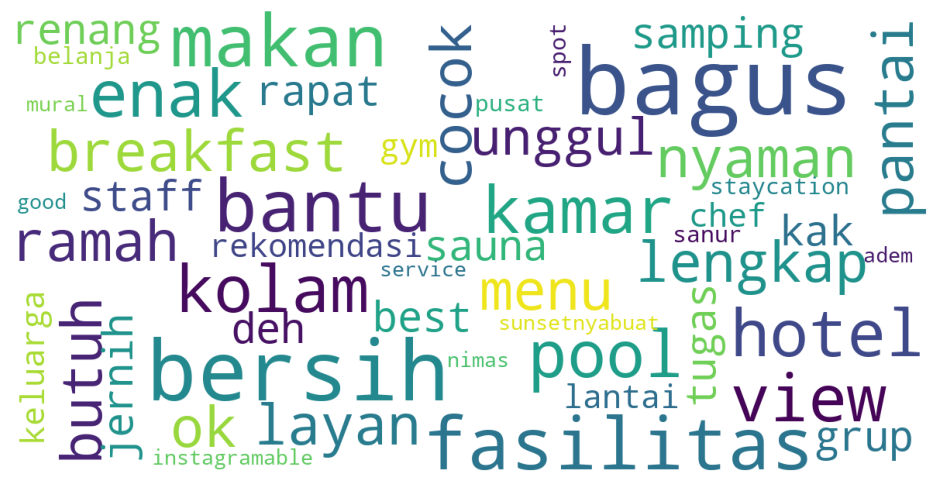

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        # stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(id_text_df['text'])
# show_wordcloud(Samsung_Reviews_positive['Reviews'])

In [34]:
pd.set_option('display.max_colwidth', None)
id_text_df.head()

,id,text
0,51,"[staycation, nyaman, pusat, belanja, pantai, sanur, spot, instagramable, mural, kamar, bagus, adem, kolam, renang, bagus, view, sunsetnyabuat, kak, nimas, good, service, deh, ya]"
1,52,"[bawa, grup, desember, butuh, beda, grup, hotel, bantu, penuh, butuh, staff, hotel, ramah, menu, sarap]"
2,53,"[fasilitas, hotel, lengkap, lokasi, fasilitas, apotek, pantai, kamar, gaya, modern, cocok, libur, jalan, bisnis, samping, makan, enak, ruang, rapat, nyaman, fasilitas, rekreasi, meja, billyard, penat, rapat]"
3,54,"[fasilitas, ok, samping, pantai, cocok, honey, moon, breakfast, lengkap, gabung, indonesia, wsetren, food, kamar, rapi, takut, sprai, bau, alam, bagus, meeting]"
4,55,"[makan, minum, enak, meetingnya, nyaman, bgttt, nginap, hotel, paket, lengkap, serba, dilayanin, servicenya, gila, sih, the, best, deh, pokok, soon]"


# Term Frequency (TF)

In [35]:
def calc_TF(document):
    # Counts the number of times the word appears in review
    TF_dict = {}
    for term in document:
        if term in TF_dict:
            TF_dict[term] += 1
        else:
            TF_dict[term] = 1
    # Computes tf for each word
    for term in TF_dict:
        TF_dict[term] = TF_dict[term] / len(document)
    return TF_dict

In [36]:
id_text_df["TF_dict"] = id_text_df['text'].progress_apply(calc_TF)

100%|██████████| 100350/100350 [00:01<00:00, 95024.50it/s]


In [37]:
id_text_df.head()

,id,text,TF_dict
0,51,"[staycation, nyaman, pusat, belanja, pantai, sanur, spot, instagramable, mural, kamar, bagus, adem, kolam, renang, bagus, view, sunsetnyabuat, kak, nimas, good, service, deh, ya]","{'staycation': 0.043478260869565216, 'nyaman': 0.043478260869565216, 'pusat': 0.043478260869565216, 'belanja': 0.043478260869565216, 'pantai': 0.043478260869565216, 'sanur': 0.043478260869565216, 'spot': 0.043478260869565216, 'instagramable': 0.043478260869565216, 'mural': 0.043478260869565216, 'kamar': 0.043478260869565216, 'bagus': 0.08695652173913043, 'adem': 0.043478260869565216, 'kolam': 0.043478260869565216, 'renang': 0.043478260869565216, 'view': 0.043478260869565216, 'sunsetnyabuat': 0.043478260869565216, 'kak': 0.043478260869565216, 'nimas': 0.043478260869565216, 'good': 0.043478260869565216, 'service': 0.043478260869565216, 'deh': 0.043478260869565216, 'ya': 0.043478260869565216}"
1,52,"[bawa, grup, desember, butuh, beda, grup, hotel, bantu, penuh, butuh, staff, hotel, ramah, menu, sarap]","{'bawa': 0.06666666666666667, 'grup': 0.13333333333333333, 'desember': 0.06666666666666667, 'butuh': 0.13333333333333333, 'beda': 0.06666666666666667, 'hotel': 0.13333333333333333, 'bantu': 0.06666666666666667, 'penuh': 0.06666666666666667, 'staff': 0.06666666666666667, 'ramah': 0.06666666666666667, 'menu': 0.06666666666666667, 'sarap': 0.06666666666666667}"
2,53,"[fasilitas, hotel, lengkap, lokasi, fasilitas, apotek, pantai, kamar, gaya, modern, cocok, libur, jalan, bisnis, samping, makan, enak, ruang, rapat, nyaman, fasilitas, rekreasi, meja, billyard, penat, rapat]","{'fasilitas': 0.11538461538461539, 'hotel': 0.038461538461538464, 'lengkap': 0.038461538461538464, 'lokasi': 0.038461538461538464, 'apotek': 0.038461538461538464, 'pantai': 0.038461538461538464, 'kamar': 0.038461538461538464, 'gaya': 0.038461538461538464, 'modern': 0.038461538461538464, 'cocok': 0.038461538461538464, 'libur': 0.038461538461538464, 'jalan': 0.038461538461538464, 'bisnis': 0.038461538461538464, 'samping': 0.038461538461538464, 'makan': 0.038461538461538464, 'enak': 0.038461538461538464, 'ruang': 0.038461538461538464, 'rapat': 0.07692307692307693, 'nyaman': 0.038461538461538464, 'rekreasi': 0.038461538461538464, 'meja': 0.038461538461538464, 'billyard': 0.038461538461538464, 'penat': 0.038461538461538464}"
3,54,"[fasilitas, ok, samping, pantai, cocok, honey, moon, breakfast, lengkap, gabung, indonesia, wsetren, food, kamar, rapi, takut, sprai, bau, alam, bagus, meeting]","{'fasilitas': 0.047619047619047616, 'ok': 0.047619047619047616, 'samping': 0.047619047619047616, 'pantai': 0.047619047619047616, 'cocok': 0.047619047619047616, 'honey': 0.047619047619047616, 'moon': 0.047619047619047616, 'breakfast': 0.047619047619047616, 'lengkap': 0.047619047619047616, 'gabung': 0.047619047619047616, 'indonesia': 0.047619047619047616, 'wsetren': 0.047619047619047616, 'food': 0.047619047619047616, 'kamar': 0.047619047619047616, 'rapi': 0.047619047619047616, 'takut': 0.047619047619047616, 'sprai': 0.047619047619047616, 'bau': 0.047619047619047616, 'alam': 0.047619047619047616, 'bagus': 0.047619047619047616, 'meeting': 0.047619047619047616}"
4,55,"[makan, minum, enak, meetingnya, nyaman, bgttt, nginap, hotel, paket, lengkap, serba, dilayanin, servicenya, gila, sih, the, best, deh, pokok, soon]","{'makan': 0.05, 'minum': 0.05, 'enak': 0.05, 'meetingnya': 0.05, 'nyaman': 0.05, 'bgttt': 0.05, 'nginap': 0.05, 'hotel': 0.05, 'paket': 0.05, 'lengkap': 0.05, 'serba': 0.05, 'dilayanin': 0.05, 'servicenya': 0.05, 'gila': 0.05, 'sih': 0.05, 'the': 0.05, 'best': 0.05, 'deh': 0.05, 'pokok': 0.05, 'soon': 0.05}"


# Inverse Document Frequency (IDF)

In [38]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

In [39]:
DF = calc_DF(id_text_df["TF_dict"])

In [40]:
import numpy as np

n_document = len(id_text_df)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict
  
#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

# Calculate TF-IDF

In [41]:
#calc TF-IDF
def calc_TF_IDF(TF):
    TF_IDF_Dict = {}
    #For each word in the review, we multiply its tf and its idf.
    for key in TF:
        TF_IDF_Dict[key] = TF[key] * IDF[key]
    return TF_IDF_Dict

#Stores the TF-IDF Series
id_text_df["TF-IDF_dict"] = id_text_df["TF_dict"].apply(calc_TF_IDF)

In [42]:
# sort descending by value for DF dictionary 
sorted_DF = sorted(DF.items(), key=lambda kv: kv[1], reverse=True)[:50]

# Create a list of unique words from sorted dictionay `sorted_DF`
unique_term = [item[0] for item in sorted_DF]

def calc_TF_IDF_Vec(__TF_IDF_Dict):
    TF_IDF_vector = [0.0] * len(unique_term)

    # For each unique word, if it is in the review, store its TF-IDF value.
    for i, term in enumerate(unique_term):
        if term in __TF_IDF_Dict:
            TF_IDF_vector[i] = __TF_IDF_Dict[term]
    return TF_IDF_vector

id_text_df["TF_IDF_Vec"] = id_text_df["TF-IDF_dict"].apply(calc_TF_IDF_Vec)

print("print first row matrix TF_IDF_Vec Series\n")
print(id_text_df["TF_IDF_Vec"][0])

print("\nmatrix size : ", len(id_text_df["TF_IDF_Vec"][0]))

print first row matrix TF_IDF_Vec Series

[0.0, 0.0, 0.0, 0.033552587089697716, 0.0, 0.0, 0.0, 0.044544965753368755, 0.09961361946054892, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09802307479859673, 0.0984755234311794, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11179204740283426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12029762635398066, 0.0, 0.0, 0.0, 0.0, 0.12545827819149696, 0.0]

matrix size :  50


In [43]:
# Convert Series to List
TF_IDF_Vec_List = np.array(id_text_df["TF_IDF_Vec"].to_list())

# Sum element vector in axis=0 
sums = TF_IDF_Vec_List.sum(axis=0)

data = []

for col, term in enumerate(unique_term):
    data.append((term, sums[col]))
    
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
2,hotel,2253.656782
8,bagus,2167.385364
4,enak,2085.125058
3,kamar,2015.794066
7,nyaman,1945.866613
0,layan,1944.417025
6,bersih,1943.680734
5,makan,1924.800904
1,ramah,1881.028236
9,inap,1789.918476
